# COMP 3359 Artificial Intelligent Application Group One
## Reimplementation of Neural Style Transfer Methods and Evaluation

### 1.The purpose of this notebook
This notebook presents the code for one out of three methods we implement on neural style transfer, namely the **model-based optimization single style methods** .

In this notebook, we shall present:
1. The overview of the neural style transfer method adopted by Dmitry Ulyanov in the [paper](https://arxiv.org/abs/1603.03417) "Texture Networks: Feed-forward Synthesis of Textures and Stylized Images" (2016)
2. The code we write based on this paper with detailed explanation and technical detail
---------------------------

### 2. Overview of this model
This method is developed upon Gaty’s idea on images based optimization model. 
Instead of directly perform optimization on pixels of generated images, which takes a long time for a single image to be generated, a generative network is built and trained so that it would take the inputs of a content images and several noise images and then generate an images of the desired content. As a result, after training, the generation of the styled images would only require **one single forward pass** of generative network, which is much more time efficient than previous Gaty’s method.

The training process of this network is more complicated than Gaty’s idea. A separate evaluation network called descriptor network is used to evaluate the generated images output by the generative network, calculating the loss function. Usually, a well-trained image classification network, like VGG 19 trained on ImageNet is used as this descriptive network. This network takes input of the generative images, content and style images separately and calculate the loss using **exactly the same** formulae given by Gaty’s image based optimization method idea. Then, **the weights in generative network**, instead of that in descriptive network is updated through backpropagation from the loss function. Notice that the descriptor network is usually pretrained standard image classification network, such as the VGG 19 network trained on ImageNet dataset.

The generative models follow a pyramidal architecture shape, that is, the content imageswould be firstly resized to a series of smaller size images with distinct dimension. Then, starting from the smallest content images, it would concatenate with a gausian noise image of the same dimension channel wisely and go through several convolutional layers. Then, such tensor would be upsampled and concatenate with content images with larger size channel wise. This process is done repeatly and final merges to one single tensor and converted to generated images of desired shape. The detailed architecture of generative network is given in the following diagram.

<center><img src='./notebookimages/1.png' width='90%'/></center>

As described above, the output of the generative network is inputed to descriptor network for evaluation and loss function calculation. Thus, the overall architecture could be expressed below.

<center><img src='./notebookimages/2.png' width='90%'/></center>

---------------------------

### 3. Implementation code
We first import necessary library. All of our implementations are based on tensorflow implementation. 

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import time
#import functools
import PIL.Image
import matplotlib.pyplot as plt

The Hyperparameter are given below. 
Several empty arrays are initilized to keep tracking of the loss through out of the training.

In [2]:
### Hyper parameter
CONTENT_LAYERS = ['block4_conv2']
STYLE_LAYERS = ['block3_conv1', 
                'block4_conv1']
EPOCH = 10
STEP = 250 
ITER_TO_SHOW = 25
BATCH_SIZE = 4

LR = 1e-3 #learning rate 

content_path = './images/contents/content04.jpg'
style_path = './images/style/style04.jpg'
CONTENT_WEIGHTS = 1
STYLE_WEIGHTS = 0
VARIATION_WEIGHTS = 0


# Training loss track
CONTENT_LOSS = []
STYLE_LOSS = []
TOTAL_LOSS = []
VARIATION_LOSS = []

Next, we shall build our model in an incremental way. 
We would build the following in sequential order
- convolutional module of generative network
- join&upsampling module of generative network
- generative network
- VGG-19 descriptive network 
- The combined final network

#### Convolutional module of generative network
The figure below shows the basic architecture of convolutional module(block), it is marked as green block in the overal architecture figure above.
<center><img src='./notebookimages/3.png' width='10%'/></center>

As suggested by the paper, circular padding is used for every convolutional layers in the convoluional block. That is, the images are topoligically considered are an dornut shape such that moving an object passes throught the left boundary of the image would reappear in the right boundary, similar for up and down direction. It essentially wraps the image from top to bottom and from left to right, just like the old fassion snake games where snake moving through the one side of game boundary would reappear in another side.

Hence, the circular padding in this context means padding the images in such way to make the dimension of input feature map and output feature map the same. Illustraed in below graph.

<center><img src='./notebookimages/4.png' width='70%'/></center>
An illustration of circular padding. Black frame means original input image with circular padding shown.
Red frame means kernal at certain position. Circular padding ensures the dimension unchanged during the covolutional layers

As a result, we first define an anxillary function to perform circular padding.

In [3]:
def CircularPadding(inputs, kernel_size = 3):
    n_channels_in = inputs.shape[-1]
    input_split = tf.split(inputs, n_channels_in, axis = -1) # Split the filter channle by channel
    output_split = []
    for x in input_split:
        x = tf.squeeze(x, axis = -1)   # X has shape (B,H,W)
        p = int(kernel_size / 2)    # padding number
        top_left = x[:, -p:, -p:] # top left
        top_center = x[:, -p:, :] # top center
        top_right = x[:, -p:, :p] # top right
        middle_left = x[:, :, -p:] # middle left
        middle_center = x # middle center
        middle_right = x[:, :, :p] # middle right
        bottom_left = x[:, :p, -p:] # bottom left
        bottom_center = x[:, :p, :] # bottom center
        bottom_right = x[:, :p, :p] # bottom right
        
        #Concatenate those parts together here
        top = tf.concat([top_left, top_center, top_right], axis=2)  
        middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
        bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
        outs = tf.concat([top, middle, bottom], axis=1)
        outs = tf.expand_dims(outs, axis = -1)
        output_split.append(outs)
    return tf.concat(output_split, axis = -1)

With the help of circular padding, we could build our convolutional block below. Using **tf.keras.models.Model** we are able to define such block as a model and it could be assmeble to our network later on. 

Notice that instead of using batch normalization which normalize across the batch of images, we perform instance normalization, which basically normalize the pixel across each image individually in different channels.Since the author's latter paper indicates that instance normalization outperform batch normalization in this particular tasks. A basical illustration of batch and instance normalization is shown below.

<center><img src='./notebookimages/5.png' width='70%'/></center>

Also, our experiement shows that Leaky ReLU is likely to output negative pixel value if the initilization of weight of neural network is bad and the training is not sufficient. Thus, as suggested by the author, we use ReLU here instead of Leaky ReLU.

In [4]:
def conv_block(input_size, in_channels, out_channels):
    inputs = tf.keras.layers.Input((input_size, input_size, in_channels, ))   # in_filters many channels of input image
    
    # first 3x3 conv
    conv1_pad = tf.keras.layers.Lambda(lambda x: CircularPadding(x))(inputs)
    conv1_out = tf.keras.layers.Conv2D(out_channels, kernel_size = (3, 3), strides = 1, 
                                       padding = 'valid', name = 'conv1')(conv1_pad)
    hidden_1 = tfa.layers.InstanceNormalization()(conv1_out)
    conv1_out_final = tf.keras.layers.ReLU(name = 'rel1')(hidden_1)
    
    # second 3x3 conv
    conv2_pad = tf.keras.layers.Lambda(lambda x: CircularPadding(x))(conv1_out_final)
    conv2_out = tf.keras.layers.Conv2D(out_channels, kernel_size = (3, 3), strides = 1, 
                                       padding = 'valid', name = 'conv2')(conv2_pad)
    hidden_2 = tfa.layers.InstanceNormalization()(conv2_out)
    conv2_out_final = tf.keras.layers.ReLU(name = 'rel2')(hidden_2)
    
    # final 1x1 conv
    conv3_out = tf.keras.layers.Conv2D(out_channels, kernel_size = (1, 1), strides = 1, 
                                       padding = 'same', name = 'conv3')(conv2_out_final)
    hidden_3 = tfa.layers.InstanceNormalization()(conv3_out)
    conv3_out_final = tf.keras.layers.ReLU(name = 'rel3')(hidden_3)
    
    # final model
    conv_block = tf.keras.models.Model(inputs, conv3_out_final)
    return conv_block

We are able to use **model.summary()** function to check whether conv block consturction is correct

In [ ]:
block = conv_block(8, 6, 8)
block.summary()

We subsequently define the join block marked yellow in the previous overview neural architecture, which composed of upsampling layers and concatination of content images and noise images of the same dimension. The detail architecture is shown below. 
<center><img src='./notebookimages/6.png' width='20%'/></center>

Similar to the convolutional block, we also replace batch normalization layers to instance normalizaiton layer here. Regarding the upsampling method, we use bilinear interpolation methods since it is more accurate and produces smooth images than nearest upsampling.

In [5]:
def join_block(input_size, n_channel_low, n_channel_high):
    input1 = tf.keras.layers.Input((input_size, input_size, n_channel_low, )) 
    input2 = tf.keras.layers.Input((2*input_size, 2*input_size, n_channel_high, ))  
    upsampled_input = tf.keras.layers.UpSampling2D(size = (2, 2))(input1)
    hidden_1 = tfa.layers.InstanceNormalization()(upsampled_input)
    hidden_2 = tfa.layers.InstanceNormalization()(input2)
    
    outputs = tf.keras.layers.Concatenate(axis=-1)([hidden_1, hidden_2])
    
    # final model
    join_block = tf.keras.models.Model([input1, input2], outputs)
    return join_block

Again, we check our join model correctness

In [ ]:
block = join_block(64, 32, 8)
block.summary()

Thus, by repeatly using the convolutional and join block define above, we can assemble then together and build our model.
Notice that during the direct downsampling of the content images, we directly resize the content images using default downsampling method, which is nearest downsampling method.

In [6]:
def generator_network():
    # create input 
    noise1 = tf.keras.layers.Input((256, 256, 3, ), name = 'noise_1')
    noise2 = tf.keras.layers.Input((128, 128, 3, ), name = 'noise_2')
    noise3 = tf.keras.layers.Input((64, 64, 3, ), name = 'noise_3')
    noise4 = tf.keras.layers.Input((32, 32, 3, ), name = 'noise_4')
    noise5 = tf.keras.layers.Input((16, 16, 3, ), name = 'noise_5')
    noise6 = tf.keras.layers.Input((8, 8, 3, ), name = 'noise_6')
    content = tf.keras.layers.Input((256, 256, 3, ), name = 'content_input')

    # downsample the content image
    content_image_8 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([8, 8])))(content)
    content_image_16 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([16, 16])))(content)
    content_image_32 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([32, 32])))(content)
    content_image_64 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([64, 64])))(content)
    content_image_128 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([128, 128])))(content)
    
    # create concatenation of downsampled content image and input nodes
    noise6_con = tf.keras.layers.Concatenate(axis=-1)([noise6, content_image_8])
    noise5_con = tf.keras.layers.Concatenate(axis=-1)([noise5, content_image_16])
    noise4_con = tf.keras.layers.Concatenate(axis=-1)([noise4, content_image_32])
    noise3_con = tf.keras.layers.Concatenate(axis=-1)([noise3, content_image_64])
    noise2_con = tf.keras.layers.Concatenate(axis=-1)([noise2, content_image_128])
    noise1_con = tf.keras.layers.Concatenate(axis=-1)([noise1, content])
    
    noise6_conv = conv_block(8, 6, 8)(noise6_con)  
    noise5_conv = conv_block(16, 6, 8)(noise5_con)   
    join5 = join_block(8, 8, 8)([noise6_conv, noise5_conv])   
    
    join5_conv = conv_block(16, 16, 16)(join5)  
    noise4_conv = conv_block(32, 6, 8)(noise4_con)   
    join4 = join_block(16, 16, 8)([join5_conv, noise4_conv])  
    
    join4_conv = conv_block(32, 24, 24)(join4)  
    noise3_conv = conv_block(64, 6, 8)(noise3_con) 
    join3 = join_block(32, 24, 8)([join4_conv, noise3_conv])   
    
    join3_conv = conv_block(64, 32, 32)(join3)   
    noise2_conv = conv_block(128, 6, 8)(noise2_con) 
    join2 = join_block(64, 32, 8)([join3_conv, noise2_conv])   
    
    join2_conv = conv_block(128, 40, 40)(join2) 
    noise1_conv = conv_block(256, 6, 8)(noise1_con)  
    join1 = join_block(128, 40, 8)([join2_conv, noise1_conv])   
    
    output = conv_block(256, 48, 3)(join1)   
    
    model = tf.keras.models.Model([content, noise1, noise2, noise3, noise4, noise5, noise6], output, name = 'generator')
    
    return model

The architecture of generator model could also be examined

In [ ]:
block = generator_network()
block.summary()

We then consider building the descriptor network, which in this case is just VGG-19 network trained on ImageNet dataset with removal of the topping fully connected layers on the last part. Similar as the image-based optimization method, we need to retrive the feature maps in intermediate layers in order to calculate the loss. The weight on this descriptor network is **NOT** trainable.

In [7]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')  # load the vgg model
    vgg.trainable = False    # do not train over vgg model parameters
  
    outputs = [vgg.get_layer(name).output for name in layer_names]    # the output of the layers that we want

    model = tf.keras.Model([vgg.input], outputs)   
    return model

Before assemble all the parts together to form the final network, we need to lastly define the auxillary funciton to calculate the gram matrix based on the feature map retrived for computation of the style loss. This time we try the tensorflow build in inner production calculation function so that we do not need to explicityly unroll the tensor and perform matrix multiplication as previous image optimization based method.

In [8]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)   # compute the sum in numerator
    input_shape = tf.shape(input_tensor)  # get the shape
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)  
    return result/(num_locations)


Then let's build our final model and define the forward pass! Remeber to preprocess the output of generative before feeding in to the descriptor network.

In [9]:
class TextureNetwork(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(TextureNetwork, self).__init__()  
        self.vgg =  vgg_layers(style_layers + content_layers)    # obtain a VGG19 model with outputs being the style and content layers
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # we are not going to train vgg network

        self.gen = generator_network()   # create a generator network as part of it
        self.gen.trainable = True   # we are going to train this generator
        

    def call(self, content, BATCH_SIZE = 16):
        # generates noise required for the network in the range [0,1]
        noise1 = tf.random.uniform((BATCH_SIZE, 256, 256, 3))
        noise2 = tf.random.uniform((BATCH_SIZE, 128, 128, 3))
        noise3 = tf.random.uniform((BATCH_SIZE, 64, 64, 3))
        noise4 = tf.random.uniform((BATCH_SIZE, 32, 32, 3))
        noise5 = tf.random.uniform((BATCH_SIZE, 16, 16, 3))
        noise6 = tf.random.uniform((BATCH_SIZE, 8, 8, 3))
    
        gen_image = self.gen([content, noise1, noise2, noise3, noise4, noise5, noise6])   # pass through the generator to obtain generated image
    
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(gen_image)  # preprocess the image
        outputs = self.vgg(preprocessed_input)  # get the output from only the required layers
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs] 

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}


        return {'gen':gen_image, 'content':content_dict, 'style':style_dict}

Since the loss function calculation requires feature maps of content images and style images extracted by VGG-19 descriptor network, we need to define another function to extract such targets for loss calculation. Then, the loss function are basically the same used as that of image optimization based method.

In [10]:
def extract_targets(inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)  # preprocess the input image
    outputs = vgg_layers(STYLE_LAYERS + CONTENT_LAYERS)(preprocessed_input)  # get the output from only the required layers
        
    style_outputs, content_outputs = (outputs[:len(STYLE_LAYERS)], 
                                       outputs[len(STYLE_LAYERS):])
        
    style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]  # create style type output to compare

    style_dict = {style_name:value
                      for style_name, value
                      in zip(STYLE_LAYERS, style_outputs)}

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(CONTENT_LAYERS, content_outputs)}

    return {'content':content_dict, 'style':style_dict}




def custom_loss(outputs, BATCH_SIZE,style_targets,content_targets):
    gen_outputs = outputs['gen']
    style_outputs = outputs['style']   # for generated image, get the style
    content_outputs = outputs['content']  # get content
    batch_loss = 0
    style_loss_batch = 0
    content_loss_batch = 0
    variation_loss_batch = 0
    for i in range(BATCH_SIZE):
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name][i]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
        style_loss *= STYLE_WEIGHTS / len(STYLE_LAYERS)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name][i]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= CONTENT_WEIGHTS / len(CONTENT_LAYERS)
        
        x_var = gen_outputs[:,:,1:,:] - gen_outputs[:,:,:-1,:]
        y_var = gen_outputs[:,1:,:,:] - gen_outputs[:,:-1,:,:]


        variation_loss = VARIATION_WEIGHTS * tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))
 
        loss = style_loss + content_loss+ variation_loss
        batch_loss += loss
        
        content_loss_batch += content_loss
        style_loss_batch += style_loss
        variation_loss_batch += variation_loss
        
    batch_loss /= BATCH_SIZE
    CONTENT_LOSS.append(content_loss_batch)
    TOTAL_LOSS.append(batch_loss)
    STYLE_LOSS.append(style_loss_batch)
    VARIATION_LOSS.append(variation_loss_batch)
    return batch_loss

Then we could train the neural network by once using the following function.

In [11]:
@tf.function()
def train_step(content_image, BATCH_SIZE,s,c):
    with tf.GradientTape() as tape:
        outputs = tex_net(content_image, BATCH_SIZE)
        loss = custom_loss(outputs, BATCH_SIZE,s,c)
        
    gradients = tape.gradient(loss, tex_net.trainable_variables)  # obtain the gradients recorded by the tape
    optimizer.apply_gradients(zip(gradients, tex_net.trainable_variables))   # apply the training rule using the gradients to modify the current value of prameters
    return outputs, loss

Before formally start training, we need to load the images first. According to the implementation details provided by the author, we resize the content images while leaving the style images unchanged to prevent possible images style destoration.


**The primary differences between our implementation and author's implementations is that the author use large amount of ImageNet and COCO dataset images to train the network to make the generative network do not overfit on particularly set of images. While due to the constrained in computational power in our group project, even with the help of GPU fram, we are not able to traing such a large amount of data. Thus, we choose an alternative approch, which means we train the network only on one sinlge content images to obtained the styled image of it, although the resultant weight of generative network may be heavily depends that content images and hence overfit, while at least this methods garantee that the code and methods actually works fine without requiring overwhlmingly amount of computational resources.**

In [12]:
def load_img(path_to_img, rescale = False):
    # we rescale the image to max dimension 256 for fasters processing
    max_dim = 256    
    img = tf.io.read_file(path_to_img)   # read the image
    img = tf.image.decode_image(img, channels=3)    # decode into image content
    img = tf.image.convert_image_dtype(img, tf.float32)    # convert to float
    
    if rescale:
        img = tf.image.resize(img, tf.constant([max_dim, max_dim]))
    else:
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)   
        # get the shape of image, cast it to float type for division, expect the last channel dimension
        long_dim = max(shape)
        scale = max_dim / long_dim    # scale accordingly
        new_shape = tf.cast(shape * scale, tf.int32)   # cast the new shape to integer
        img = tf.image.resize(img, new_shape)   # resize image
        
    img = img[tf.newaxis, :]   # newaxis builts a new batch axis in the image at first dimension
    return img

style_image = load_img(style_path, rescale = False)
content_image = load_img(content_path, rescale = True)

# We concatenate the content image to form a batch to use the advantages of mini batch to accelearate training
my_content = tf.concat([content_image for _ in range(BATCH_SIZE)], axis = 0)

We have a look about the content images and the style images used.

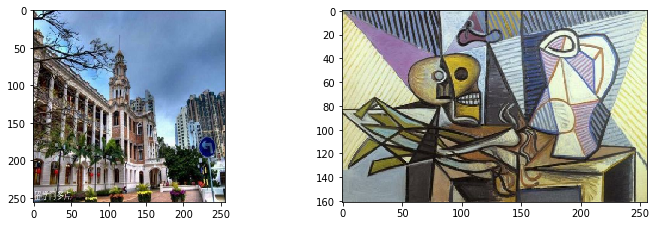

In [13]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(tf.cast(content_image[0]*255,tf.int16))
fig.add_subplot(rows, columns, 2)
plt.imshow(tf.cast(style_image[0]*255,tf.int16))
plt.show()

We extract the target feature map of content and style images using descriptor network for loss calculation and instantiate the correponding optimizer and neural network for training.

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)  # use an Adam optimizer
tex_net = TextureNetwork(STYLE_LAYERS, CONTENT_LAYERS)   # create the texture network
style_image = load_img(style_path, rescale = False)
content_image = load_img(content_path, rescale = True)
style_targets = extract_targets(style_image)['style']
content_targets = extract_targets(content_image)['content']

Let's start training !

Epoch: 0
Loss:  tf.Tensor(3950224.8, shape=(), dtype=float32)
tf.Tensor(9.412804, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


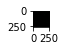

KeyboardInterrupt: 

In [15]:
start_time = time.time()
for epoch in range(EPOCH):
    msg = 'Epoch: ' + str(epoch)
    print(msg)
    for step in range(STEP):
        outputs, loss = train_step(my_content, batch_size,style_targets,content_targets)
        if step % iter_to_show_output == 0:
            print("Content_loss")
            print(CONTENT_LOSS[-1])
            print("Style_loss")
            print(STYLE_LOSS[-1])
            
            print('Loss: ', loss)
            tex_net.save_weights('./checkpoints11/my_checkpoint')
    img = tex_net(content_image, 1)['gen']
    fig=plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 1, 1)
    img = tf.cast(tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=255),tf.int16)
    plt.imshow(img[0])
    plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))
    
print("Final loss data")
print("Content_loss:",CONTENT_LOSS[-1])
print("Style_loss:",STYLE_LOSS[-1])
print("Variation_loss:",VARIATION_LOSS[-1])
    
print("STYLE LOSS BY LAYERS")
for i,name in enumerate(STYLE_LAYERS):
    print(name,STYLE_LOSS_P[i][-1])

fig, ax = plt.subplots()
plt.title("Training loss")
ax.set_yscale('log')
ax.plot(CONTENT_LOSS, label='Contentloss')
ax.plot(STYLE_LOSS, label='Styleloss')
ax.plot(VARIATION_LOSS, label='variationloss')
plt.grid()
plt.legend()
plt.show()